In [1]:
import pandas as pd
import geopandas as gp
import numpy as np 
import os
import fiona
from statistics import mean, median
import string
import sys
from IPython.display import IFrame

# VEST AL 2017
---

## VEST Documentation

### Election Results

#### Sources
Election results from the Alabama Secretary of State Elections Division (https://www.sos.alabama.gov/alabama-votes/voter/election-data). 

Incorrect or incomplete data was replaced using the county canvass reports for the following counties: Dallas, Chilton, Covington, Lauderdale, Lawrence, Marion, Monroe, Tuscaloosa.

#### Processing
Absentee and provisional ballots were reported countywide in all counties. These were distributed by candidate to precincts based on their share of the precinct-level reported vote.

The Clay County precinct results include total write in votes by precinct whereas the certified state canvass only includes official write in totals for Clay County. For DeKalb County the certified state canvass omits the provisional votes. For Monroe County the certified state canvass appears to have a typographic error that adds 10 votes for Jones (D).


### Shapefiles

#### Sources
Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

### Processing
Precinct boundaries were adjusted where appropriate to align with county maps, municipal boundaries, or commission districts. Precinct boundaries throughout the state were further reviewed with the voter registration file in effect for the November 2017 general election. Voting districts in nearly all counties were edited accordingly to align with reporting units in the 2017 election results. In many counties the resulting boundaries bear little resemblance to the 2020 Census VTDs. As these boundary revisions were so extensive only splits and merges are specified below by precinct.

Many precincts have outdated names in the Census VTDs. The Census VTDs also have at least some precinct names in wrong locations for the following counties: Clarke, Clay, Cleburne, Conecuh, Dallas, Escambia, Geneva, Greene, Jefferson, Lauderdale, Limestone, Marion, Marshall, Monroe, Perry, Randolph, Russell, Tallapoosa, Walker, Washington, Wilcox. Moreover, many precinct numbers and consequently the VTD GeoIDs are also incorrect throughout much of the state in the Census shapefiles. All precinct names and numbers have been edited to match the 2017 voter file.

The following splits and merges were made to align voting district boundaries with reporting units in the 2017 election results.

- Autauga: Merge Boone's Chapel/County Line
- Barbour: Split Eufaula between Bevill/CC/Fellowship/McCoo/Sanford/WB
- Calhoun: Add precinct splits to Beats 1, 4, 5, 9, 12, 13, 15, 19, 22
- Cherokee: Split Friendship/Mt Calvary, McCord's/Rock Run, Mt Weisner/VFD #2
- Choctaw: Split Cromwell/Halsell/Intersection
- Clarke: Split Antioch/Grove Hill/Helwestern, Choctaw Bluff/Gainstown, Grove Hill NG/Whatley, Jackson/Skipper, Springfield/Thomasville; Merge Fulton FS/CH
- Covington: Split Heath/Straughn, Pleasant Home/Wing
- Cullman: Split Cullman City Hall/Civic Ctr/Conf Room/Courthouse
- Dallas: Merge Marion Jct/New Friendship
- Elmore: Merge Grandview Pines/Nazarene
- Fayette: Split Browns Glen Allen/Whites Chapel, Cole Killingsworth/New River, Elm Grove/Studdards, Fayette CC/Covin/YC, Lee-Belk/Oak Ridge
- Geneva: Split Bellwood/Chancellor, Flat Creek/Hacoda, Geneva CC/CH/CO/FC/NG, Hughes VH/Malvern, Lowery/Revels, Piney Grove/Samson/Samson Masonic, Slocomb/Tate
- Houston: Split Enterprise/Lovetown; Merge Mt Gilead/Water & Electric
- Jackson: Split Holly Springs/Pleasant Groves
- Jefferson: Merge 2350/5270 as Oxmoor Valley, 5110/5180 as Mountain Brook City Hall
- Lee: Split Boykin/National Guard
- Marion: Split Kimbrough N/S; Merge Hamilton N/S as ET Sims
- Marshall: Split Arab Comm Ctr/Rec Ctr, Guntersville/Warrenton
- Monroe: Split Chrysler/Mineola, Coleman/Excel, Franklin/Wainwright, Peterman/Philadelphia
- Randolph: Split Bethel/Moores/Woodland, Cavers/Swagg, Corinth/Morrison, Midway/New Hope/Wedowee, Omaha/Tin Shop/Wehadkee, Rock Mills/Wilson
- Russell: Split Courthouse/Golden Acres
- Tallapoosa: Split Cooper/Duncan/Moncrief; Merge New Paces 901/902 to match county shapefile
- Wilcox: Split National Guard Camden, Pine Apple Comm Ctr, Pine Apple AWIN, St Paul Church
- Winston: Split Addison/Upshaw, Delmar/Natural Bridge, Haleyville/Neighborhood/Pebble/Waldrop, Lynn/Old Union, Nesmith/Helicon


# Election Result Processing

## Get VEST file and FIPS dictionary ready

### Load in VEST file

In [2]:
vest_al_17 = gp.read_file("./raw-from-source/VEST/al_2017/al_2017.shp")

In [3]:
vest_al_17.crs

<Geographic 2D CRS: EPSG:4269>
Name: NAD83
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: North America - onshore and offshore: Canada - Alberta; British Columbia; Manitoba; New Brunswick; Newfoundland and Labrador; Northwest Territories; Nova Scotia; Nunavut; Ontario; Prince Edward Island; Quebec; Saskatchewan; Yukon. Puerto Rico. United States (USA) - Alabama; Alaska; Arizona; Arkansas; California; Colorado; Connecticut; Delaware; Florida; Georgia; Hawaii; Idaho; Illinois; Indiana; Iowa; Kansas; Kentucky; Louisiana; Maine; Maryland; Massachusetts; Michigan; Minnesota; Mississippi; Missouri; Montana; Nebraska; Nevada; New Hampshire; New Jersey; New Mexico; New York; North Carolina; North Dakota; Ohio; Oklahoma; Oregon; Pennsylvania; Rhode Island; South Carolina; South Dakota; Tennessee; Texas; Utah; Vermont; Virginia; Washington; West Virginia; Wisconsin; Wyoming. US Virgin Islands. British Virgin Islands

<AxesSubplot:>

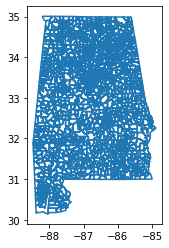

In [4]:
vest_al_17.boundary.plot()

In [5]:
vest_al_17.columns

Index(['STATEFP20', 'COUNTYFP20', 'VTDST17', 'GEOID17', 'NAME17', 'S17USSRMOO',
       'S17USSDJON', 'S17USSOWRI', 'geometry'],
      dtype='object')

In [6]:
vest_al_17.head(5)

,STATEFP20,COUNTYFP20,VTDST17,GEOID17,NAME17,S17USSRMOO,S17USSDJON,S17USSOWRI,geometry
0,01,013,000100,01013000100,Monterey School House,13,22,0,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
1,01,013,000181,01013000181,Bolling,45,39,0,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
2,01,053,000080,01053000080,Rock Hill-Ridge VFD,111,52,2,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
3,01,053,000120,01053000120,Damascus-Boykin School,74,111,2,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
4,01,053,000100,01053000100,Bradley VFD,39,3,0,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."


### Create a FIPs dictionary

In [7]:
#Load in the nationwide FIPS file
fips_file = pd.read_csv("./raw-from-source/FIPS/US_FIPS_Codes.csv")
fips_file = fips_file[fips_file["State"]=="Alabama"]
fips_file["FIPS County"]=fips_file["FIPS County"].astype(str)

#Make the FIPS three digits
fips_file["FIPS County"]=fips_file["FIPS County"].str.zfill(3)

#Create the dictionary
al_fips_dict = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

## Election Results

### Load, Pivot, Clean Election Results

There is a directory of excel files that need to be pivoted of election results. 

First, confirm that the file structure is the same for all of the files:

In [8]:
files = os.listdir('./raw-from-source/SOS/2017-Special-General-PrecinctLevel/')

In [9]:
temp = pd.read_excel('./raw-from-source/SOS/2017-Special-General-PrecinctLevel/2017-General-Autauga.xls')
columns = temp.columns
print(columns)

flag = True
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2017-Special-General-PrecinctLevel/' + file)
    if columns.to_list()[:3] != temp.columns.to_list()[:3]:
        print(columns)
        print(temp.columns)
        flag = False
if flag:
    print('All files have the same first 3 columns: ', columns.to_list()[:3])

Index(['Contest Title', 'Party', 'Candidate', '0040 E_MEMORIAL CHRISTIAN',
       '10 JONES COMMUNITY CTR', '100 TRINITY METHODIST',
       '110 CENTRAL AL ELECTRIC', '140 AUTAUGAVILLE VFD',
       '150 PRATTMONT BAPTIST CH', '160 DOSTER COMMUNITY CTR',
       '170 CAMELLIA BAPTIST CH', '180 OLD KINGSTON VFD',
       '20 HERITAGE BAPTIST', '220 UPPER KINGSTON',
       '30 BILLINGSLEY COMM_ CTR_', '50 WHITE CITY VFD',
       '60 MARBURY MIDDLE SCH', '70 BOONE'S CHAPEL', '80 INDEPENDENCE VFD',
       '90 BOOTH VFD', 'ABSENTEE', 'PROVISIONAL'],
      dtype='object')
All files have the same first 3 columns:  ['Contest Title', 'Party', 'Candidate']


Next, go through and pivot each file, clean them, and concatenate. 

In [10]:
def pivot_clean_county_file(df, county_name): 
    """Given a dataframe, pivot the table, order and rename columns, and return the cleaned table that can be concatenated. """
    
    df_pivot = pd.pivot_table(df,values=[x for x in df.columns.to_list() if x not in ('Contest Title','Party','Candidate')],
                              columns=['Contest Title',"Candidate"],aggfunc=sum)
    df_pivot['county'] = county_name
    df_pivot.reset_index(inplace = True)
    df_pivot.columns = [(x.strip(), y.strip()) for x,y in df_pivot.columns.values]
    
    if county_name in ('Lauderdale', 'Tuscaloosa'):
        df_pivot['UNITED STATES SENATOR', 'Write-In'] = 0
            
    clean_df = df_pivot[[('index',''),('county',''),
                        ('UNITED STATES SENATOR', 'Roy S. Moore'), ('UNITED STATES SENATOR', 'Doug Jones'), ('UNITED STATES SENATOR', 'Write-In')]]
    
    clean_df.columns = ['precinct','county','S17USSRMOO','S17USSDJON','S17USSOWRI']
    
    return clean_df



In [11]:
flag = 0
for file in files: 
    temp = pd.read_excel('./raw-from-source/SOS/2017-Special-General-PrecinctLevel/' + file)
#     print(file.split('-')[2][:-4])
    clean_df = pivot_clean_county_file(temp, file.split('-')[2][:-4])
    if flag == 0:
        results_2017 = clean_df
        flag = 1
    else:
        results_2017 = pd.concat([results_2017, clean_df])

Add county fips to election results file

In [12]:
# Change column names to match the county fips dict
results_2017.loc[results_2017['county'] == 'StClair', 'county'] = 'St Clair'
results_2017.loc[results_2017['county'] == 'DeKalb', 'county'] = 'De Kalb'

#Map to the correct FIP
results_2017["county_fips"]=results_2017["county"].map(al_fips_dict).fillna(results_2017["county"])

#Print out the FIPS to make sure they all are in the correct format
results_2017["county_fips"].unique()

array(['011', '037', '105', '017', '111', '133', '099', '081', '021',
       '049', '127', '033', '087', '123', '073', '023', '063', '093',
       '035', '029', '041', '019', '089', '129', '109', '031', '057',
       '119', '115', '053', '121', '131', '077', '113', '009', '005',
       '027', '013', '003', '107', '101', '007', '069', '103', '001',
       '061', '059', '067', '095', '043', '085', '025', '047', '091',
       '015', '075', '039', '045', '125', '097', '065', '051', '079',
       '117', '055', '071', '083'], dtype=object)

In [13]:
results_2017.shape

(2235, 6)

In [14]:
vest_al_17.shape

(1996, 9)

## Compare Election Results Totals

### Compare Total Votes

In [15]:
races = [x for x in vest_al_17.columns if 'S17' in x]
races

['S17USSRMOO', 'S17USSDJON', 'S17USSOWRI']

In [16]:
sum_var_1 = 0
sum_var_2 = 0
for i in races:
    sum_var_1 += np.sum(vest_al_17[i])
    sum_var_2 += np.sum(results_2017[i])
print(sum_var_1)
print(sum_var_2)

1348749
1345756.0


### Compare County Totals

The `compare()` method shows rows where the values are different, by default. So displaying nothing here is good, all county race totals are equal. 

In [17]:
vest_al_17.groupby('COUNTYFP20')['S17USSRMOO'].sum().compare(results_2017.groupby('county_fips')['S17USSRMOO'].sum())

,self,other
021,7563.0,6987.0
039,6835.0,6825.0
047,3487.0,3118.0
053,4987.0,4985.0
079,5321.0,5314.0
093,5269.0,5190.0


In [18]:
count = 0
votes_to_add = pd.DataFrame(columns=["county","candidate","value"])
diff_counties=[]
for i in races:
    diff = results_2017.groupby(['county_fips']).sum()[i]-vest_al_17.groupby(['COUNTYFP20']).sum()[i]
    for val in diff[diff != 0].index.values.tolist():
        if val not in diff_counties:
            diff_counties.append(val)
    if len(diff[diff != 0]!=0):
        print(i)
        print(diff[diff != 0].to_string(header=False))
        for index,row in diff[diff != 0].iteritems():
            votes_to_add.loc[count] = [index,i,-int(row)]
            count+=1
print("All other races in all counties are equal")

print(diff_counties)
print(votes_to_add)

al_fips_dict = dict(zip(fips_file["FIPS County"],fips_file["County Name"]))

for county in diff_counties:
    print(al_fips_dict[county])

S17USSRMOO
021   -576.0
039    -10.0
047   -369.0
053     -2.0
079     -7.0
093    -79.0
S17USSDJON
021   -138.0
039     -5.0
047   -367.0
053     -2.0
079     -5.0
093    -20.0
S17USSOWRI
021     -14.0
047      -4.0
077    -388.0
125   -1007.0
All other races in all counties are equal
['021', '039', '047', '053', '079', '093', '077', '125']
   county   candidate value
0     021  S17USSRMOO   576
1     039  S17USSRMOO    10
2     047  S17USSRMOO   369
3     053  S17USSRMOO     2
4     079  S17USSRMOO     7
5     093  S17USSRMOO    79
6     021  S17USSDJON   138
7     039  S17USSDJON     5
8     047  S17USSDJON   367
9     053  S17USSDJON     2
10    079  S17USSDJON     5
11    093  S17USSDJON    20
12    021  S17USSOWRI    14
13    047  S17USSOWRI     4
14    077  S17USSOWRI   388
15    125  S17USSOWRI  1007
Chilton
Covington
Dallas
Escambia
Lawrence
Marion
Lauderdale
Tuscaloosa


In [19]:
#Making sure we aren't adding any negative votes
print(min(votes_to_add["value"]))

votes_to_add_pivot = pd.pivot_table(votes_to_add,index=["county"],values="value",columns=["candidate"],aggfunc=sum)
votes_to_add_pivot.reset_index(inplace=True,drop=False)
votes_to_add_pivot = votes_to_add_pivot.fillna(0)
print(votes_to_add_pivot)

2
candidate county  S17USSDJON  S17USSOWRI  S17USSRMOO
0            021       138.0        14.0       576.0
1            039         5.0         0.0        10.0
2            047       367.0         4.0       369.0
3            053         2.0         0.0         2.0
4            077         0.0       388.0         0.0
5            079         5.0         0.0         7.0
6            093        20.0         0.0        79.0
7            125         0.0      1007.0         0.0


### Compare Race Totals

In [20]:
for race in races:
    diff_val = sum(vest_al_17[race])-sum(results_2017[race])
    if diff_val != 0:
        print(race+": "+str(diff_val), "\tVEST sum: ", sum(vest_al_17[race]), "\tRDH sum: ", sum(results_2017[race]))
    else:
        print(race+": EQUAL")

S17USSRMOO: 1043.0 	VEST sum:  651983 	RDH sum:  650940.0
S17USSDJON: 537.0 	VEST sum:  673889 	RDH sum:  673352.0
S17USSOWRI: 1413.0 	VEST sum:  22877 	RDH sum:  21464.0


In [21]:
def statewide_totals_check(partner_df,source_df,column_list):
    print("***Statewide Totals Check***")
    for race in column_list:
        if (sum(partner_df[race])- source_df[race].sum() != 0):
            print(race+" has a difference of "+str(sum(partner_df[race])-source_df[race].sum())+" votes")
            print("\tVEST: "+str(sum(partner_df[race]))+" votes")
            print("\tSOURCES: "+str(source_df[race].sum())+" votes")
        else:
            print(race + " is equal", "\tVEST / RDH: " + str(sum(partner_df[race])))

In [22]:
statewide_totals_check(vest_al_17,results_2017,races)

***Statewide Totals Check***
S17USSRMOO has a difference of 1043.0 votes
	VEST: 651983 votes
	SOURCES: 650940.0 votes
S17USSDJON has a difference of 537.0 votes
	VEST: 673889 votes
	SOURCES: 673352.0 votes
S17USSOWRI has a difference of 1413.0 votes
	VEST: 22877 votes
	SOURCES: 21464.0 votes


### Compare Precinct-by-Precinct

In [23]:
results_2017["unique_ID"] = results_2017["county_fips"] +"-"+results_2017["precinct"]

vest_al_17["unique_ID"] = vest_al_17["COUNTYFP20"] +"-"+vest_al_17["NAME17"].str.upper()

pro_ab_list = list(results_2017[(results_2017["precinct"].str.contains("ABSENTEE")) |(results_2017["precinct"].str.contains("PROVISIONAL"))| (results_2017["unique_ID"].isin(["031-PROVISONAL","039-PROVSIONAL","101-ABSEN","101-PROVI"]))]["unique_ID"])

In [24]:
print(pro_ab_list)

non_prov_absentee = results_2017[~results_2017["unique_ID"].isin(pro_ab_list)]
prov_absentee = results_2017[results_2017["unique_ID"].isin(pro_ab_list)]

['011-ABSENTEE', '011-PROVISIONAL', '037-ABSENTEE', '037-PROVISIONAL', '105-ABSENTEE', '105-PROVISIONAL', '017-ABSENTEE', '017-PROVISIONAL', '111-ABSENTEE', '111-PROVISIONAL', '133-ABSENTEE', '133-PROVISIONAL', '099-ABSENTEE', '099-PROVISIONAL', '081-ABSENTEE', '081-PROVISIONAL', '049-ABSENTEE', '049-PROVISIONAL', '127-ABSENTEE', '127-PROVISIONAL', '033-ABSENTEE', '033-PROVISIONAL', '087-ABSENTEE', '087-PROVISIONAL', '123-ABSENTEE', '123-PROVISIONAL', '073-BESSEMER ABSENTEE', '073-BIRMINGHAM ABSENTEE', '073-PROVISIONAL', '023-ABSENTEE', '023-PROVISIONAL', '063-ABSENTEE', '063-PROVISIONAL', '093-ABSENTEE', '093-PROVISIONAL', '035-ABSENTEE', '035-PROVISIONAL', '029-ABSENTEE', '029-PROVISIONAL', '041-ABSENTEE', '041-PROVISIONAL', '019-ABSENTEE', '019-PROVISIONAL', '089-ABSENTEE', '089-PROVISIONAL', '129-ABSENTEE', '129-PROVISIONAL', '109-ABSENTEE', '109-PROVISIONAL', '031-ABSENTEE', '031-PROVISONAL', '057-ABSENTEE', '057-PROVISIONAL', '119-ABSENTEE', '119-PROVISIONAL', '115-ABSENTEE', '11

In [25]:
def vote_merger (merge_list,new_name):
    global non_prov_absentee
    races = [x for x in vest_al_17.columns if 'S17' in x]

    #Add in the other votes
    
    for i in range(1,len(merge_list)):
        for race in races:
            non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],race]+=int(non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[i],race])
    
    #Update the unique ID
    non_prov_absentee.loc[non_prov_absentee["unique_ID"]==merge_list[0],"unique_ID"]=new_name
    
    #Remove the ones that aren't needed
    non_prov_absentee = non_prov_absentee[~non_prov_absentee["unique_ID"].isin(merge_list[1:])]
    
    non_prov_absentee.reset_index(inplace=True,drop=True)

In [26]:
non_prov_absentee["ID_len"] = non_prov_absentee["unique_ID"].apply(lambda x: x[0:len(x)-3] if x[0:3]=="097" else x)

#Load in the nationwide FIPS file
names_97 = pd.read_csv("./97_names.csv")

#Create the dictionary
names_97_dict = dict(zip(names_97["og_names"],names_97["new_names"]))

names_097 = list(non_prov_absentee[non_prov_absentee["unique_ID"].str[0:3]=="097"]["ID_len"].unique())

#Make a dictionary that maps from these names to the shortened 097

for i in names_097:
    merge_list = list(non_prov_absentee[non_prov_absentee["unique_ID"].str.contains(i)]["unique_ID"])
    #Create a dictionary here
    new_name = names_97_dict[i]
    vote_merger(merge_list,new_name)

<ipython-input-26-6c4b0fc01390>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_prov_absentee["ID_len"] = non_prov_absentee["unique_ID"].apply(lambda x: x[0:len(x)-3] if x[0:3]=="097" else x)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)
/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/pandas/core/indexing.py:1720: SettingWithC

In [27]:
vote_merger(["043-FAIRVIEW FIRE DEPT_ (A-K)","043-FAIRVIEW TOWN HALL (L-Z)"],"043-FAIRVIEW FD/TOWN HALL")
vote_merger(["049-FORT PAYNE SENIOR CITIZEN #1","049-FORT PAYNE SENIOR CITIZEN #2"],"049-FORT PAYNE SENIOR CTR")
vote_merger(["049-RAINSVILLE #1","049-RAINSVILLE #2"],"049-RAINSVILLE DEKALB SCHOOLS")
vote_merger(["049-WILLS VALLEY REC CTR #1","049-WILLS VALLEY REC CTR #2"],"049-WILLS VALLEY REC CENTER")
vote_merger(["049-VFW HALL LOBBY-FORT PAYNE #1","049-VFW HALL LOBBY-FORT PAYNE #2"],"049-VFW HALL")
vote_merger(["111-NATIONAL GUARD ARMORY #1","111-NATIONAL GUARD ARMORY #2","111-NATIONAL GUARD ARMORY #3"],"111-NATIONAL GUARD ARMORY")
vote_merger(["111-WEDOWEE CITY HALL #1","111-WEDOWEE CITY HALL #2"],"111-WEDOWEE CITY HALL")



In [28]:
attempt_one = pd.merge(non_prov_absentee,vest_al_17,on="unique_ID",how="outer",indicator=True)
print(attempt_one["_merge"].value_counts())



source_vest_id_changes = pd.read_csv("./source_vest_id_changes.csv")
source_vest_id_changes_dict = dict(zip(source_vest_id_changes["source_ID"],source_vest_id_changes["vest_ID"]))

vals_to_delete = []
print(len(source_vest_id_changes_dict))
for val in source_vest_id_changes_dict:
    if source_vest_id_changes_dict[val] not in list(vest_al_17["unique_ID"]):
        vals_to_delete.append(val)

for val in vals_to_delete:
    del source_vest_id_changes_dict[val]

print(len(source_vest_id_changes_dict))


non_prov_absentee["unique_ID"] = non_prov_absentee["unique_ID"].map(source_vest_id_changes_dict).fillna(non_prov_absentee["unique_ID"])

attempt_one = pd.merge(non_prov_absentee,vest_al_17,on="unique_ID",how="outer",indicator=True)
print(attempt_one["_merge"].value_counts())

elections_only = attempt_one[attempt_one["_merge"]=="left_only"]
elections_only.to_csv("./only_elections.csv")

vest_only = attempt_one[attempt_one["_merge"]=="right_only"]
vest_only.to_csv("./only_vest.csv")

right_only    1322
left_only     1319
both           674
Name: _merge, dtype: int64
1467
1408
both          1969
right_only      29
left_only       24
Name: _merge, dtype: int64


# Precinct Shapefile

## Documentation

> Precinct shapefiles primarily from the U.S. Census Bureau's 2020 Redistricting Data Program final release, except the following counties use shapefiles sourced from the respective county governments instead: Baldwin, Blount, Calhoun, Cullman, DeKalb, Franklin, Jefferson, Lee, Limestone, Madison, Marengo, Marshall, Mobile, Morgan, St. Clair, Shelby, Talladega, Tuscaloosa.

Note: There are four separate categories:
1. Counties where VEST used data from the U.S. Census Bureau's 2020 Redistricting Data Program final release
2. Counties where VEST sourced shapefiles from the respective county government and we were able to find a shapefile
3. Counties where VEST sourced shapefiles from the respective county government and we were able to find some sort of map
4. Counties where VEST sourced shapefiles from the respective county government and we were unable to find any information

For validation purposes, we can group together (1) and (2), work on (3) separately, and there won't be anything to do with (4).

### Work to split up shapefiles / election results into these categories

In [29]:
al_fips_dict_mod = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

alt_source = ["Baldwin", "Blount", "Calhoun", "Cullman", "De Kalb", 
              "Franklin", "Jefferson", "Lee", "Limestone", "Madison", 
              "Marengo", "Marshall", "Mobile", "Morgan", "St Clair", "Shelby", "Talladega", "Tuscaloosa"]

diff_fips_list = []
for val in alt_source:
    diff_fips_list.append(al_fips_dict_mod[val])

## 1. Counties w/ Census Source

Link to the 2020 TIGER/Line files for AL, where we can download the VTD file, assuming the file did not change: 
https://www2.census.gov/geo/tiger/TIGER2020PL/STATE/01_ALABAMA/01/

In [30]:
tiger_vtd = gp.read_file('./raw-from-source/Census/tl_2020_01_vtd20/tl_2020_01_vtd20.shp')

census_source = tiger_vtd[~(tiger_vtd["COUNTYFP20"].isin(diff_fips_list))]

In [31]:
tiger_vtd.head(1)
print(tiger_vtd.shape)

(1837, 15)


## 2. Precinct Boundaries from County - Shapefile Available (0)
No counties fall into this category

In [32]:
census_source

,STATEFP20,COUNTYFP20,VTDST20,GEOID20,VTDI20,NAME20,NAMELSAD20,LSAD20,MTFCC20,FUNCSTAT20,ALAND20,AWATER20,INTPTLAT20,INTPTLON20,geometry
0,01,013,000010,01013000010,A,MONTEREY SCHOOL HOUSE,MONTEREY SCHOOL HOUSE,00,G5240,N,52684413,65831,+31.9295188,-086.8948172,"POLYGON ((-86.90894 31.96167, -86.90632 31.961..."
6,01,013,000020,01013000020,A,BOILING,BOILING,00,G5240,N,34263687,9587,+31.7419101,-086.6953937,"POLYGON ((-86.71867 31.73289, -86.71864 31.732..."
60,01,053,000080,01053000080,A,Rock Hill-Ridge VFD,Rock Hill-Ridge VFD,00,G5240,N,77283382,845364,+31.1243492,-086.9703988,"POLYGON ((-87.05166 31.11854, -87.04869 31.118..."
61,01,053,000120,01053000120,A,Damascus-Boykin School,Damascus-Boykin School,00,G5240,N,239970985,2927814,+31.1863271,-086.8610253,"POLYGON ((-86.95858 31.16635, -86.95844 31.166..."
62,01,053,000100,01053000100,A,Bradley VFD,Bradley VFD,00,G5240,N,117582466,202906,+31.0407000,-086.7610470,"POLYGON ((-86.82985 31.02083, -86.82983 31.020..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1832,01,053,000310,01053000310,A,Atmore City Hall,Atmore City Hall,00,G5240,N,4713997,40082,+31.0336232,-087.4850527,"POLYGON ((-87.49742 31.03981, -87.49713 31.041..."
1833,01,053,000250,01053000250,A,Catawba Springs,Catawba Springs,00,G5240,N,5397312,41772,+31.0104264,-087.5041875,"POLYGON ((-87.51493 30.99761, -87.51489 30.997..."
1834,01,053,000330,01053000330,A,Nokomis VFD,Nokomis VFD,00,G5240,N,50659913,62759,+31.0258867,-087.5767447,"POLYGON ((-87.61566 31.02666, -87.61542 31.040..."
1835,01,053,000280,01053000280,A,Little Rock Store,Little Rock Store,00,G5240,N,54384951,454418,+31.1114262,-087.3919267,"POLYGON ((-87.45446 31.11949, -87.45423 31.119..."


## Attempt to join election results to precinct boundaries where shapefile exists

In [33]:


results_2017_census = non_prov_absentee[~(non_prov_absentee["county_fips"].isin(diff_fips_list))]

census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAME20"].str.upper()
#census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAMELSAD20"].str.upper()

print(census_source["unique_ID"].value_counts(dropna=False))


join_attempt_one = pd.merge(results_2017_census,census_source,on="unique_ID",how="outer",indicator=True)
print(join_attempt_one["_merge"].value_counts())

shapes_only = join_attempt_one[join_attempt_one["_merge"]=="left_only"]
shapes_only.to_csv("./only_shapes.csv")

elections_only = join_attempt_one[join_attempt_one["_merge"]=="right_only"]
elections_only.to_csv("./only_elections.csv")

023-LUSK                    1
031-UNASSIGNED              1
101-FRAZER UM CHURCH        1
111-GRAHAM                  1
053-RIVERVIEW TOWN HALL     1
                           ..
099-BURNT CORN FD           1
057-BOLEY SPRINGS CHURCH    1
077-OAKLAND FIRE ST         1
113-CVCC                    1
127-CORONA BAPTIST CH       1
Name: unique_ID, Length: 1078, dtype: int64
both          745
left_only     391
right_only    334
Name: _merge, dtype: int64


/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


In [34]:
shape_election_id_changes = pd.read_csv("./shape_election_id_changes_new.csv")

shape_election_id_changes_dict = dict(zip(shape_election_id_changes["shape_ID"],shape_election_id_changes["election_ID"]))

census_source["unique_ID"] = census_source["unique_ID"].map(shape_election_id_changes_dict).fillna(census_source["unique_ID"])

In [35]:
join_attempt_two = pd.merge(results_2017_census,census_source,on="unique_ID",how="outer",indicator=True)
print(join_attempt_two["_merge"].value_counts())

both          1007
left_only      131
right_only      74
Name: _merge, dtype: int64


In [36]:
shapes_only = join_attempt_two[join_attempt_two["_merge"]=="left_only"]
shapes_only.to_csv("./only_shapes.csv")

elections_only = join_attempt_two[join_attempt_two["_merge"]=="right_only"]
elections_only.to_csv("./only_elections.csv")

## Attempt to join election results to precinct boundaries where shapefile exists

In [37]:
print(results_2017_census)
print(census_source.columns)

census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAME20"].str.upper()
census_source["unique_ID"] = census_source["COUNTYFP20"]+"-"+census_source["NAMELSAD20"].str.upper()


join_attempt_one = pd.merge(results_2017_census,census_source,on="unique_ID",how="outer",indicator=True)
join_attempt_one["_merge"].value_counts()

                       precinct   county  S17USSRMOO  S17USSDJON  S17USSOWRI  \
0                      ABERFOIL  Bullock        28.0       115.0         0.0   
1                       CORINTH  Bullock        15.0        12.0         0.0   
2                   CORNERSTONE  Bullock        39.0       178.0         0.0   
3                   FITZPATRICK  Bullock        97.0        56.0         1.0   
4      GUERRYTON/SEHOY PLANT RD  Bullock         0.0        53.0         0.0   
...                         ...      ...         ...         ...         ...   
1963          SKYLINE CITY HALL  Jackson       282.0        60.0        13.0   
1964        STEVENSON CITY PARK  Jackson       372.0       262.0         5.0   
1965          TRENTON FIRE HALL  Jackson        28.0        13.0         0.0   
1966     TUPELO/PIKEVILLE STORE  Jackson       137.0        22.0         2.0   
1967  WOODVILLE BOB JONES COMM_  Jackson       248.0        87.0         7.0   

     county_fips                   uniq

/Users/peterhorton/opt/anaconda3/envs/geo_env/lib/python3.9/site-packages/geopandas/geodataframe.py:1322: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


both          745
left_only     391
right_only    334
Name: _merge, dtype: int64

<AxesSubplot:>

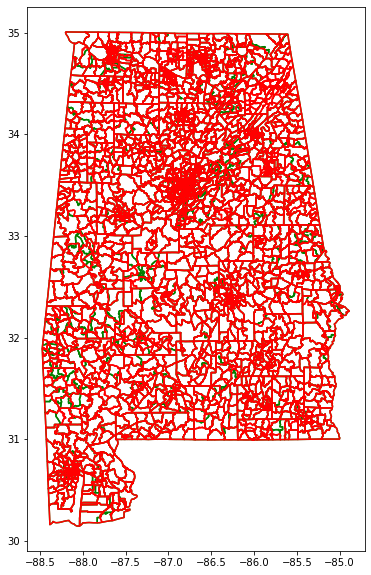

In [38]:
#Plot what they look like on top of one another, looks similar to what VEST has
ax = tiger_vtd.boundary.plot(figsize=(10,10),color="green")
vest_al_17.boundary.plot(figsize=(10,10),ax=ax,color="red")

## 3. Precinct Boundaries from County - Non-Shapefile Map Available (10)
10 counties fall into this category:

1. Baldwin County  
Link: https://baldwincountyal.gov/government/probate-office/elections/district-maps-voting-precincts  
Note: they have a GIS department but only PDF map available on the website at that link.  
2. Calhoun County  
Link: https://www.calhouncounty.org/forms/Commission_Districts_Voting.pdf  
Note: only finding a PDF map on their website.  
3. Limestone County  
Link: https://www.votelimestone.com/related-links/limestone-county-beat-map-with-polling-locations/  
Note: only finding a PDF map on their website.  
4. Madison County  
Link: https://www.madisoncountyvotes.com/voter-resources/polling-locations/  
Note: their interactive precinct map only shows the polling locations, but not precinct boundaries.  
5. Mobile County  
Link: https://www.mobilecountyal.gov/government/departments/administration/gis-mapping/election-maps/  
Note: only finding a PDF map on their website. You can request GIS maps by mail request form.  
6. Morgan County  
Link: https://www.morgancountyelections.com/election-information/precinct-maps/  
Note: there is an interactive arcgis precinct map, but there is no download option. Emailed Kate Terry, the Chief Clerk at kterry@morgancounty-al.gov.  
7. St. Clair County  
Link: https://stclair.maps.arcgis.com/apps/webappviewer/index.html?id=63f82a53398c49d38bf0e036e163e08a  
Note: there is an interactive argis precinct map, but there is no download option. Emailed gissupport@stclairco.com  
8. Shelby County  
Link: https://maps.shelbyal.com/html5/  
Note: there is an interactive arcgis precinct map, but there is no download option. Called the county IT Services (205-670-6981), and told to call back and ask for Victoria at 1pm (6/4/2021).  
9. Talladega County  
Link: https://www.talladegacountyal.org/departments/voter_registration/county_district_maps.php  
Note: only finding a PDF map from 2013. Unlikely that they have a shapefile because the map looks like a scan of a physical copy.   
10. Cullman County  
Note: not finding a precinct map on their county website, there is a jpg map in the Cullman Times from 2014 at this   link: https://www.cullmantimes.com/cullman-county-voting-precincts-map/image_0269f200-6231-11e4-9024-af8efe886238.html

### Baldwin

['Marlow/Fish River VFD', 'Spanish Fort New Life Assembly', 'Ellisville Comm Ctr', 'Loxley Civic Ctr', 'Stapleton VFD', 'Fairhope 3 Circle Church', 'Spanish Fort Church of Christ', 'Rosinton UMC', 'Belforest Comm Ctr', 'Silverhill Comm Ctr', 'Fairhope Avenue Baptist', 'Bethel Baptist', 'Daphne High', 'Elberta Civic Ctr', 'Graham Creek Interpretive Ctr', 'Douglasville Boykin Ctr', 'Stockton Civic Bldg', 'Rabun VFD', 'Pine Grove VFD Station #1', 'White House Fork VFD', 'PZK Hall', 'Bay Minette Civic Ctr', 'Gulf Shores Cultural Ctr', 'Lillian Community Club', 'Peridido Beach VFD', 'Josephine VFD', 'Daphne Civic Ctr', 'Spanish Fort Comm Ctr', 'Bromley-Crossroads VFD', 'Crossroads Durant Chapel Baptist', 'Old Vaughn School', 'Tensaw VFD', 'Little River VFD', 'Lottie VFD', 'Fort Morgan VFD #1', 'Fairhope Civic Ctr', 'Pt Clear St Francis Pt Anglican', 'Mars Hill Church', 'Barnwell VFD', 'Magnolia Springs Wesleyan', "Bon Secour Morgan's Chapel UMC", 'Orange Beach Comm Ctr', 'Gulf Shores Meyer 

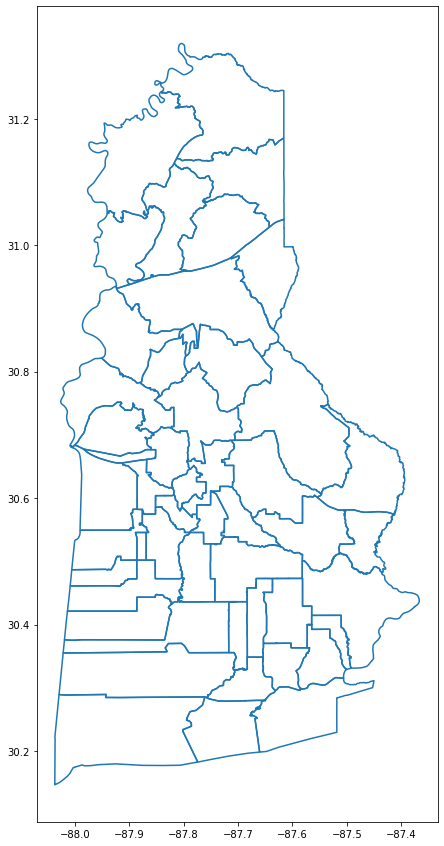

In [74]:
vest_al_17[vest_al_17["COUNTYFP20"]=="003"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="003"]["NAME20"]))

In [80]:

IFrame("./raw-from-source/County_Shapefiles/Baldwin/2021_Baldwin_Precincts.pdf", width=900, height=900)

In [79]:
IFrame("./raw-from-source/County_Shapefiles/Baldwin/Voting-Precincts-and-Voting-Places-in-Baldwin-County-AL-(PUBLIC)---Revised-July-20-2020908144dd-8fd7-4d13-acd2-d6032a3905ec.pdf", width=900, height=900)

### Calhoun

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="015"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="015"]["NAME20"]))

In [81]:
IFrame("./raw-from-source/County_Shapefiles/Calhoun/Commission_Districts_Voting.pdf", width=900, height=900)

### Limestone

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="083"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="083"]["NAME20"]))

In [ ]:
IFrame("./raw-from-source/County_Shapefiles/Limestone/2020-Limestone-County-Beat-Map-with-Polling-Locations.pdf", width=900, height=900)

### Madison

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="089"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="089"]["NAME20"]))

In [82]:
IFrame("./raw-from-source/County_Shapefiles/Madison/2020-Polling-Loations-as-of-7-14-2020.pdf", width=900, height=900)

### Mobile

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="097"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="097"]["NAME20"]))

In [ ]:
IFrame("./raw-from-source/County_Shapefiles/Mobile/Precincts2020.pdf", width=900, height=900)

### Morgan

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="103"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="103"]["NAME20"]))

In [83]:
IFrame("./raw-from-source/County_Shapefiles/Morgan/Map_Screenshot.png", width=900, height=900)

### St. Clair

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="115"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="115"]["NAME20"]))

In [84]:
IFrame("./raw-from-source/County_Shapefiles/St_Clair/Map_Screenshot.png", width=900, height=900)

### Shelby

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="117"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="117"]["NAME20"]))

In [85]:
IFrame("./raw-from-source/County_Shapefiles/Shelby/Map_Screenshot.png", width=900, height=900)

### Talladega

In [ ]:
vest_al_17[vest_al_17["COUNTYFP20"]=="121"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="121"]["NAME20"]))

In [86]:
IFrame("./raw-from-source/County_Shapefiles/Talladega/voting precints map.pdf", width=900, height=900)

### Cullman

['Vinemont Comm Ctr', 'Arkadelphia FD', 'Providence FD', 'Bethsadia FD', 'Gold Ridge Comm Ctr', 'Berlin Comm Ctr', 'Welti Mt Zion Church', 'Joppa VFD', 'Friendship Church', 'Crane Hill FD', 'Moody Town Union Hill Church', 'Dodge City Comm Ctr', 'Valley Grove Comm Ctr', 'Simcoe Comm Ctr', 'Hanceville City Hall', 'Trimble Fire Dept', 'Colony Education Complex', 'Baileyton Senior Ctr', 'Brushy Pond Comm Ctr', 'Bremen FD', 'Garden City Town Hall', 'West Point Comm Ctr', 'Stouts Mountain Church', 'Hanceville Civic Ctr', 'Baldwin Comm Ctr', 'Grandview Comm Ctr', 'Johnson Crossing VFD', 'Beat 8 Comm Ctr', 'Brooklyn Comm Ctr', 'Center Hill Comm Ctr', 'Walter Comm Ctr', 'Holly Pond FD', 'Cullman Co Health Dept', 'Good Hope City Hall', 'Donald E Green Senior Ctr', 'Cullman Co Office Bldg', 'Kelley Comm Ctr', 'East Point Comm Ctr', 'Bolte White Grove Church', 'Cullman City Hall', 'Battleground FD', 'Bethel Comm Ctr', 'Jones Chapel FD', 'Logan FD', 'New Canaan Senior Ctr', 'Fairview FD/Town Hall',

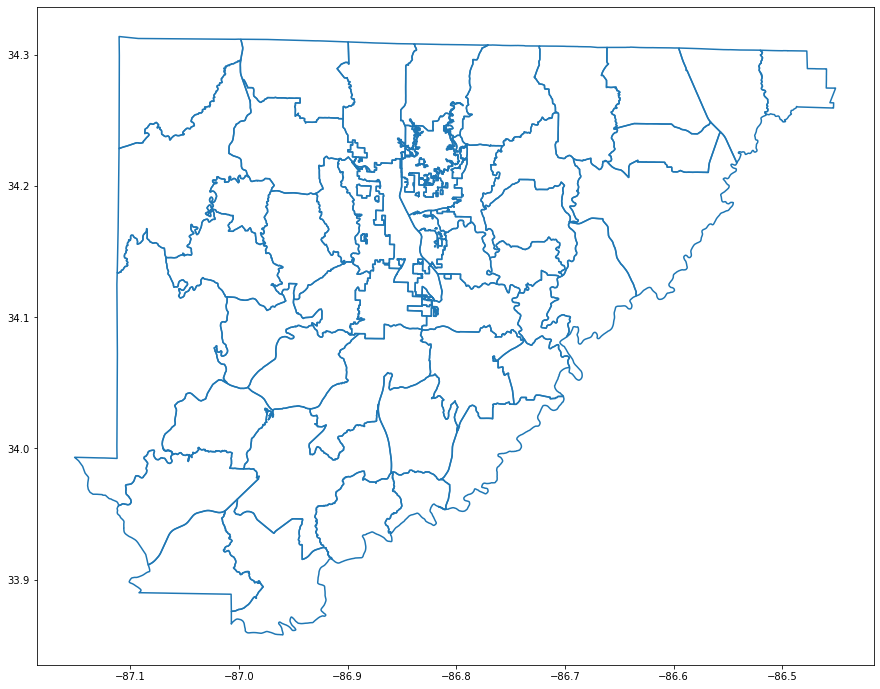

In [88]:
vest_al_17[vest_al_17["COUNTYFP20"]=="043"].boundary.plot(figsize=(15,15))
print(list(vest_al_17[vest_al_17["COUNTYFP20"]=="043"]["NAME20"]))

In [87]:
IFrame("./raw-from-source/County_Shapefiles/Cullman/54558b3036051.image.jpg", width=900, height=900)

## 4. Precinct Boundaries from County - No Map Available (8)
8 counties fall into this category:
1. Dekalb
2. Franklin
3. Jefferson
4. Lee
5. Marengo
6. Marshall
7. Tuscaloosa
8. Blount

Note: Precinct changes over time are listed for Jefferson County (https://jeffcoprobatecourt.com/elections/voting-precinct-changes/) and polling locations are listed for Marshall and Tuscaloosa Counties.

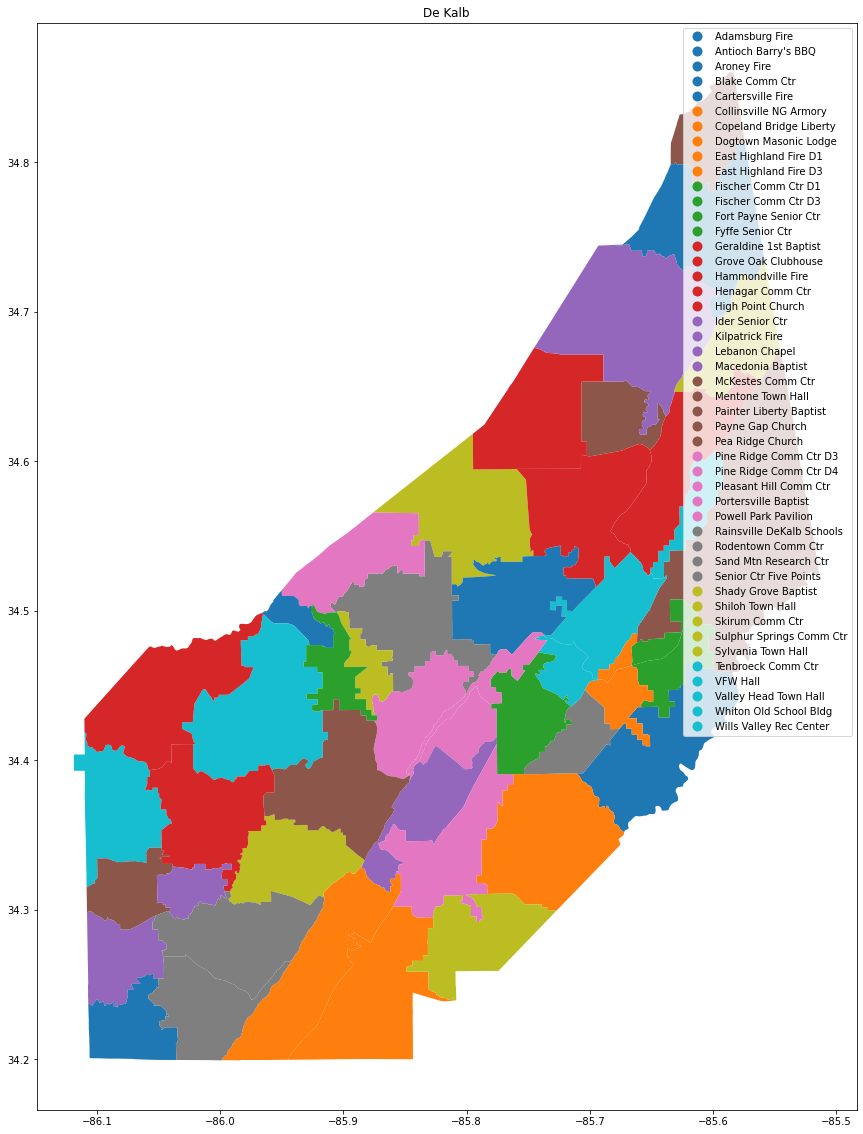

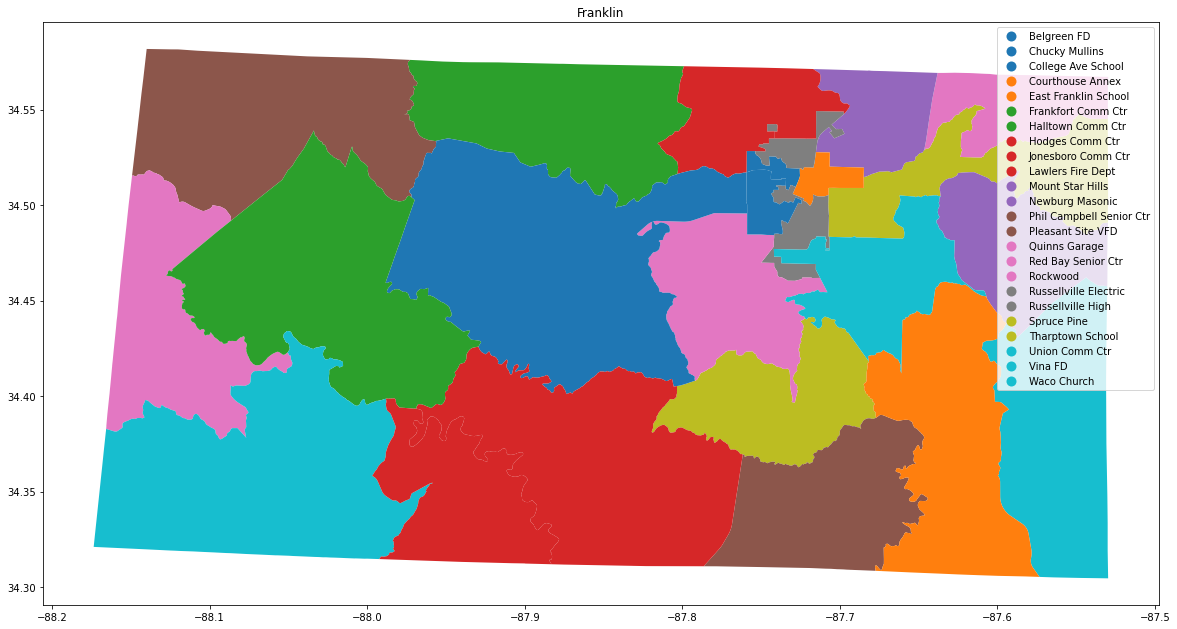

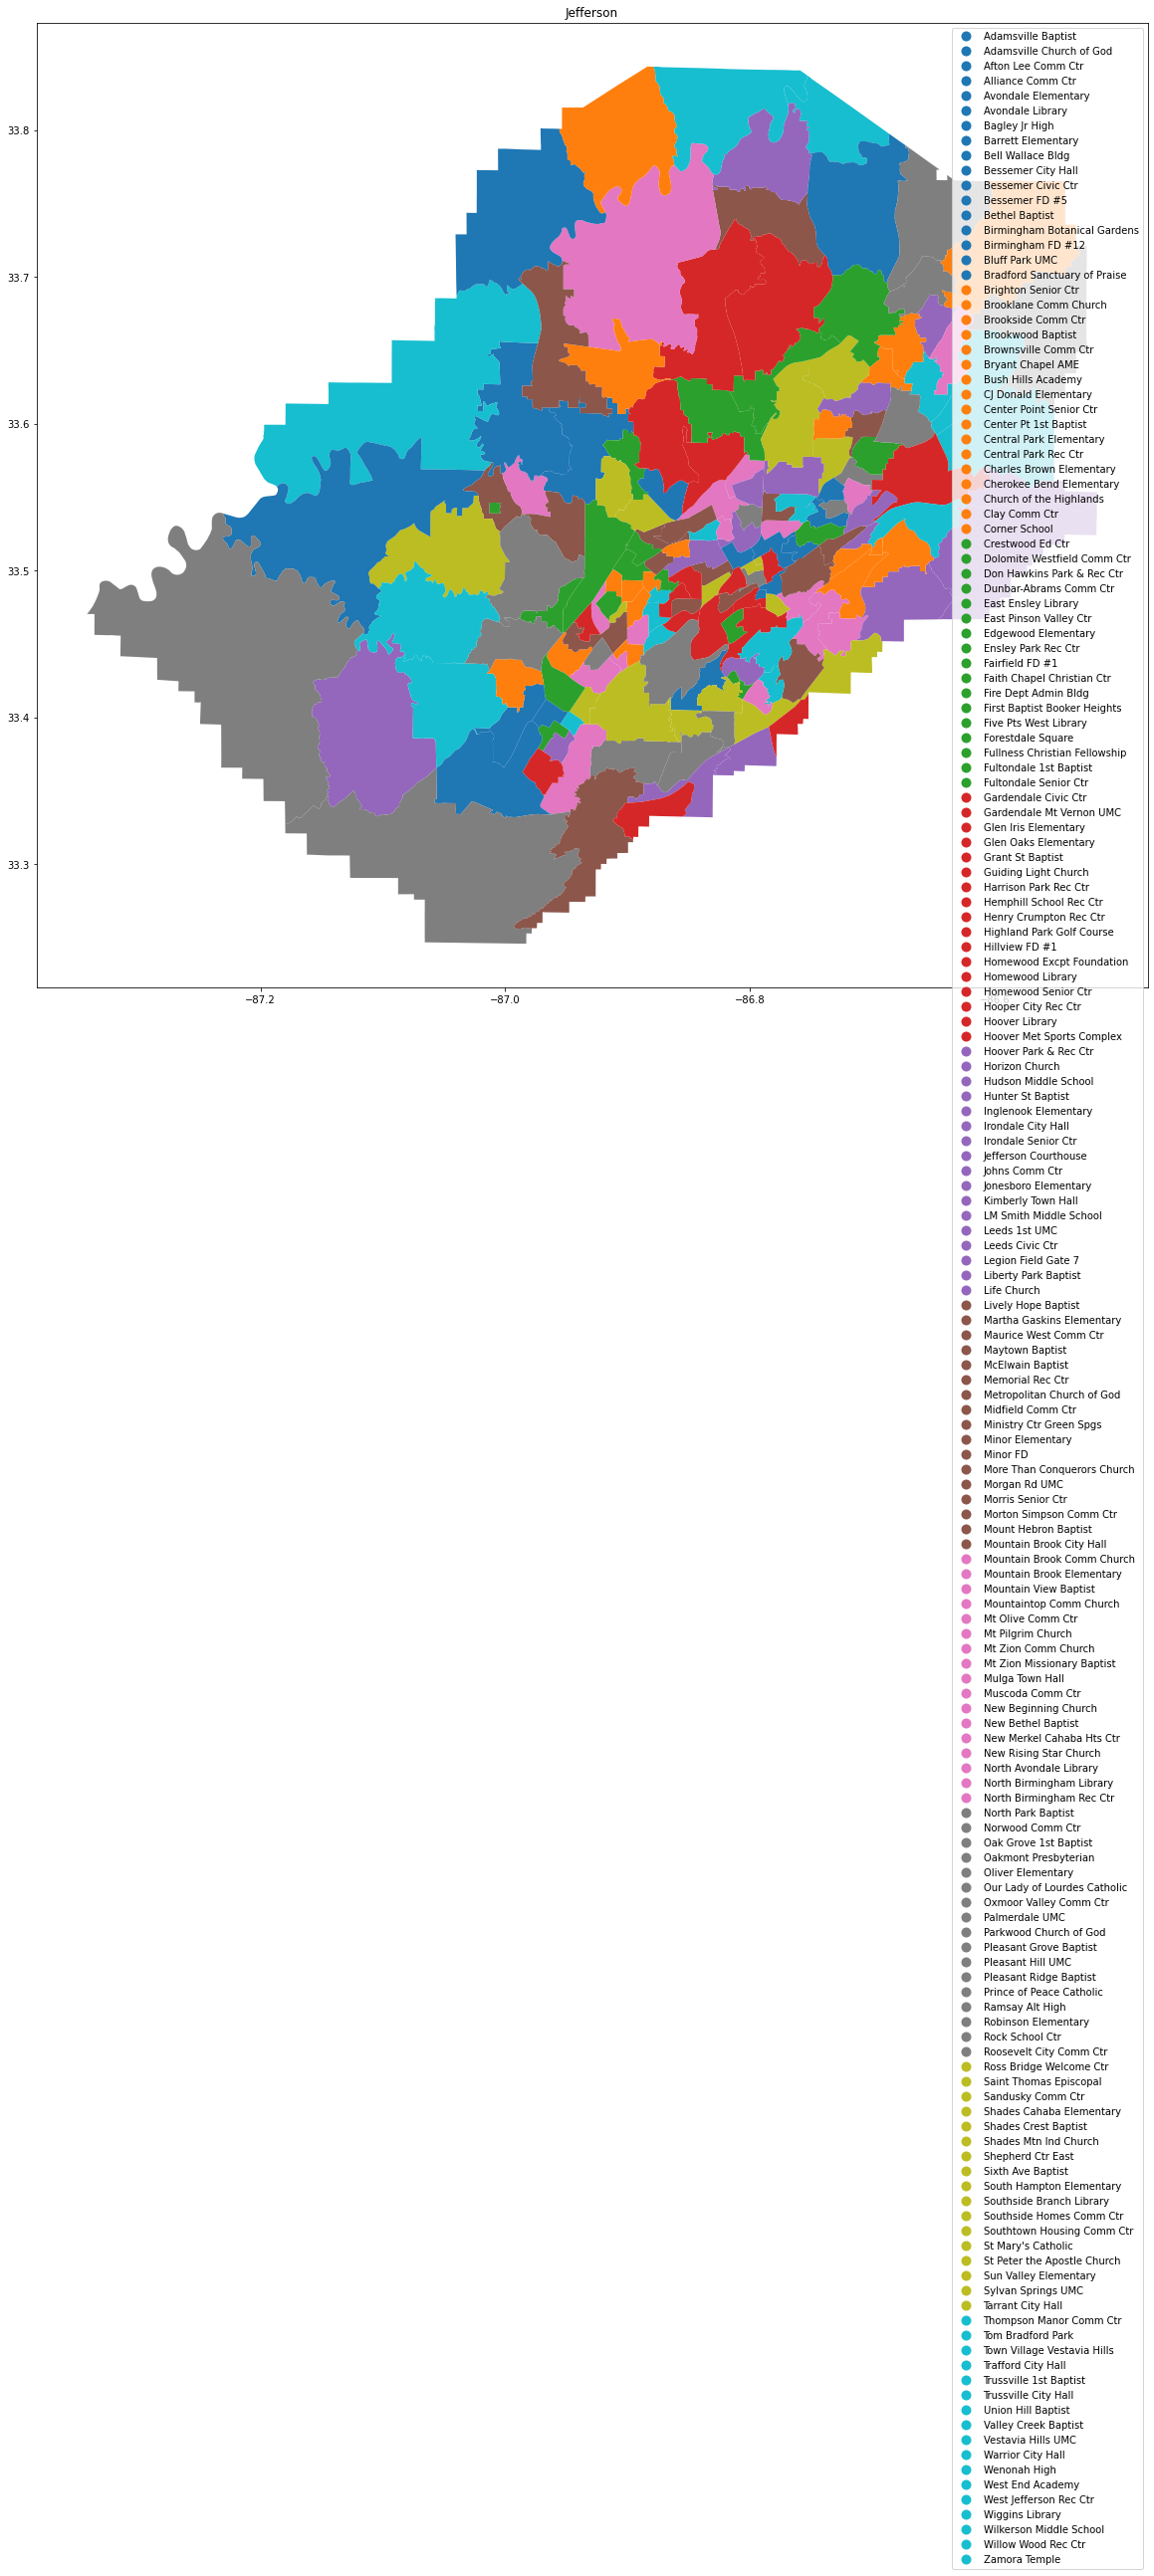

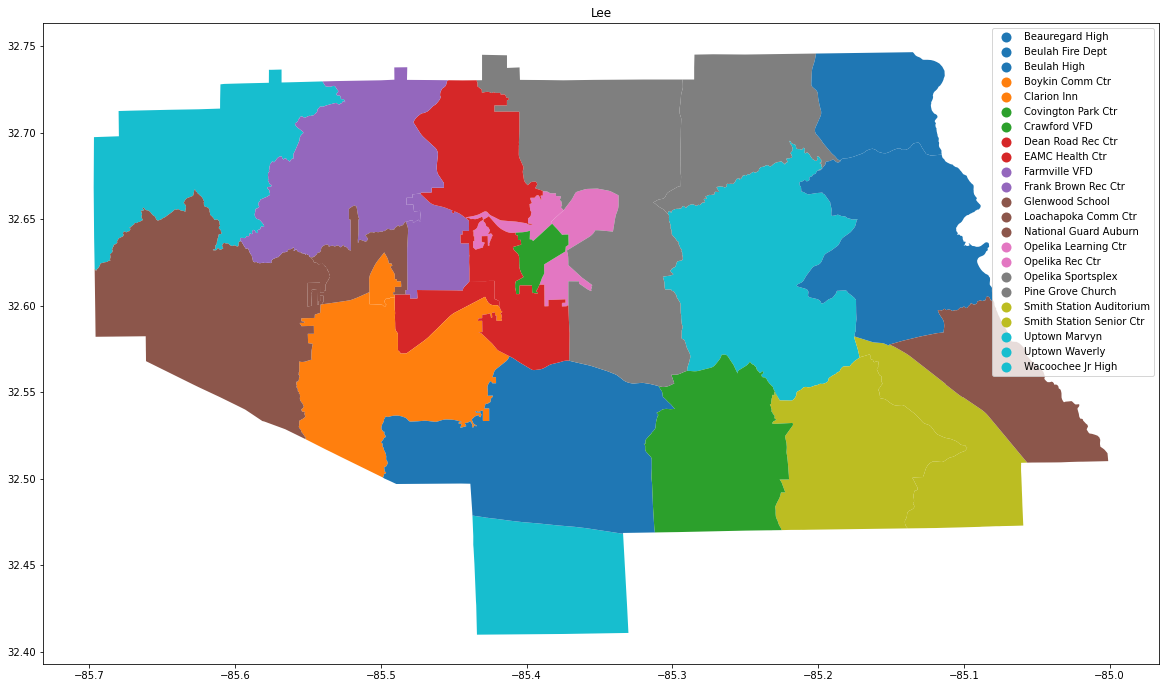

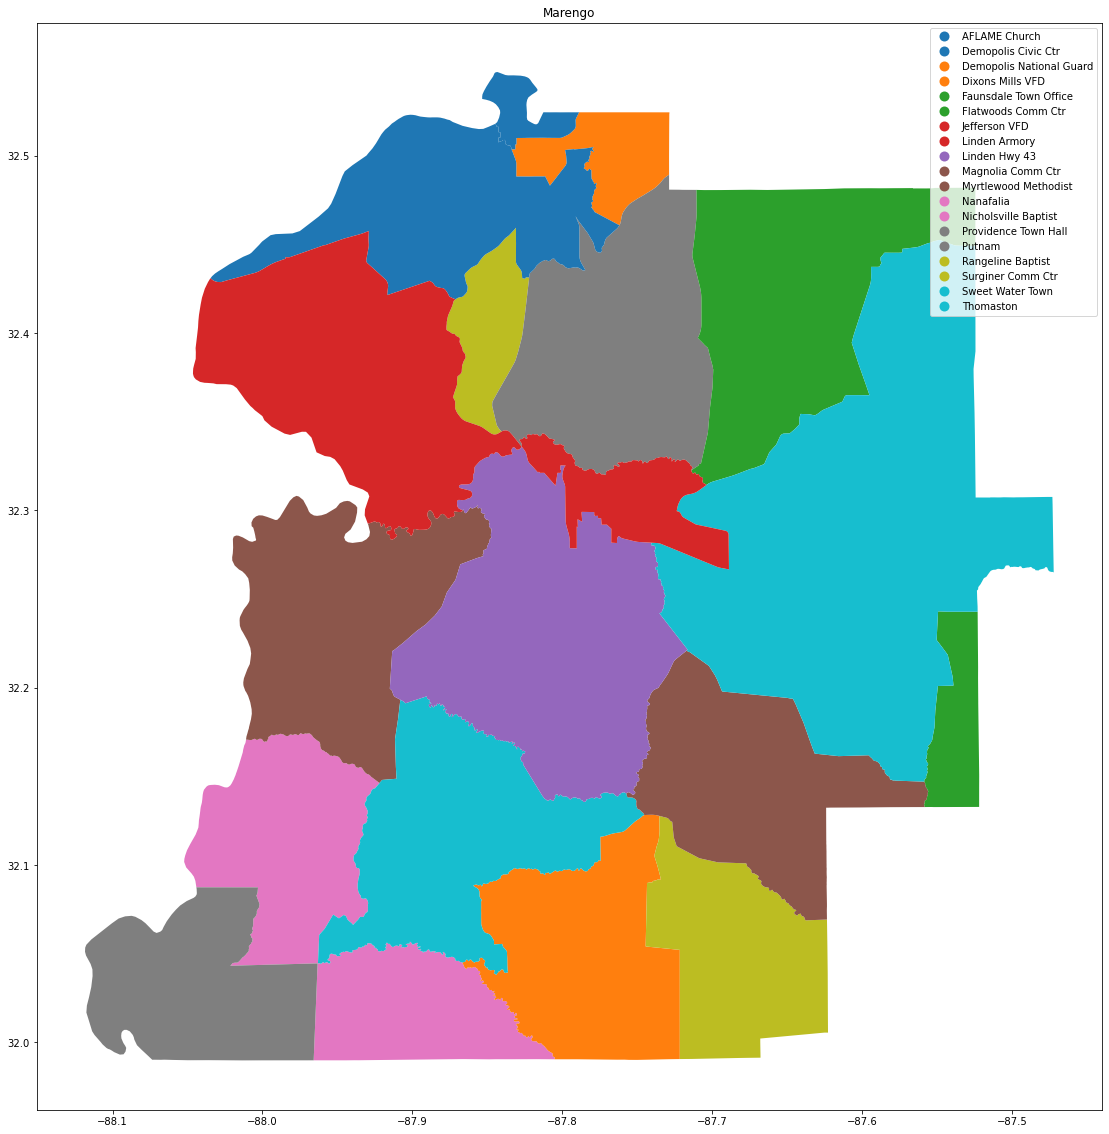

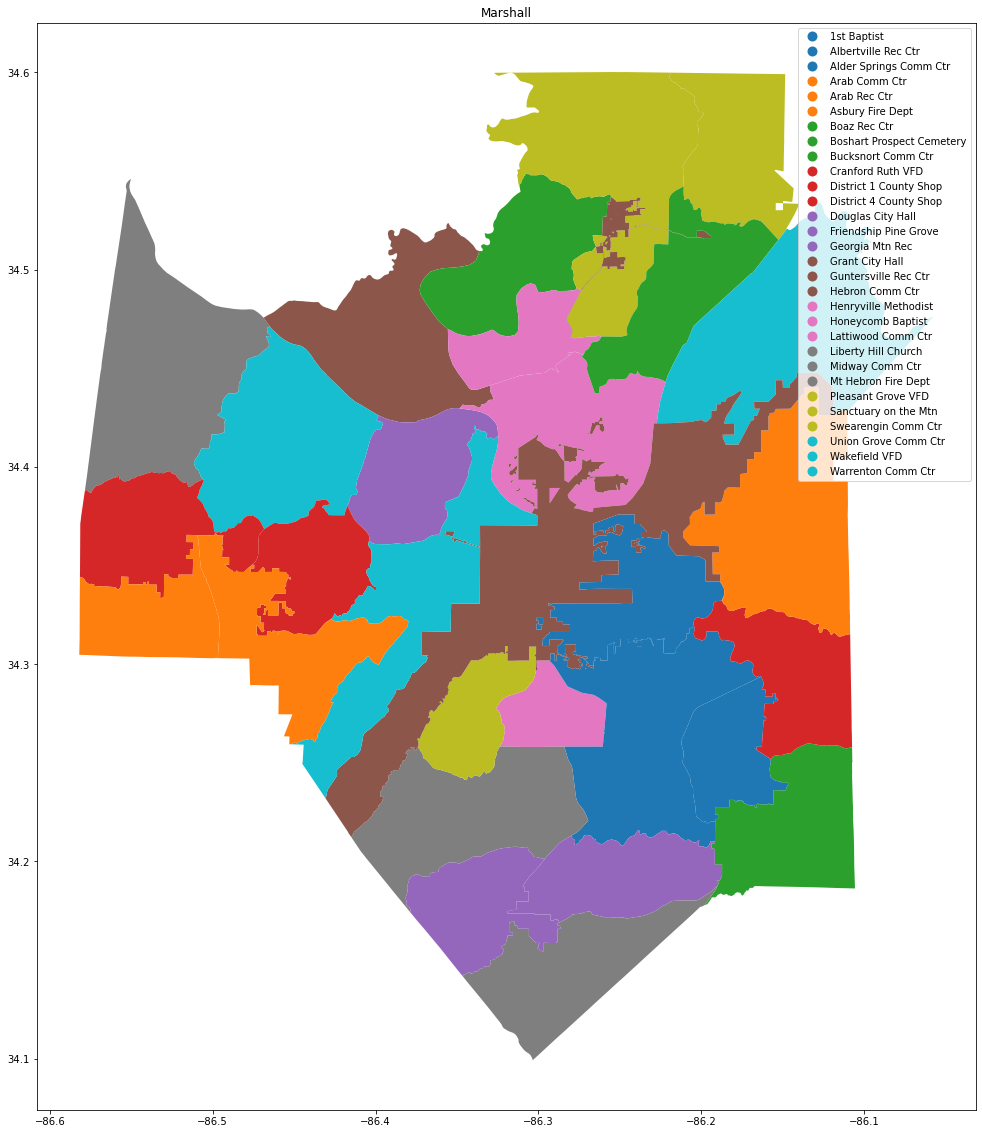

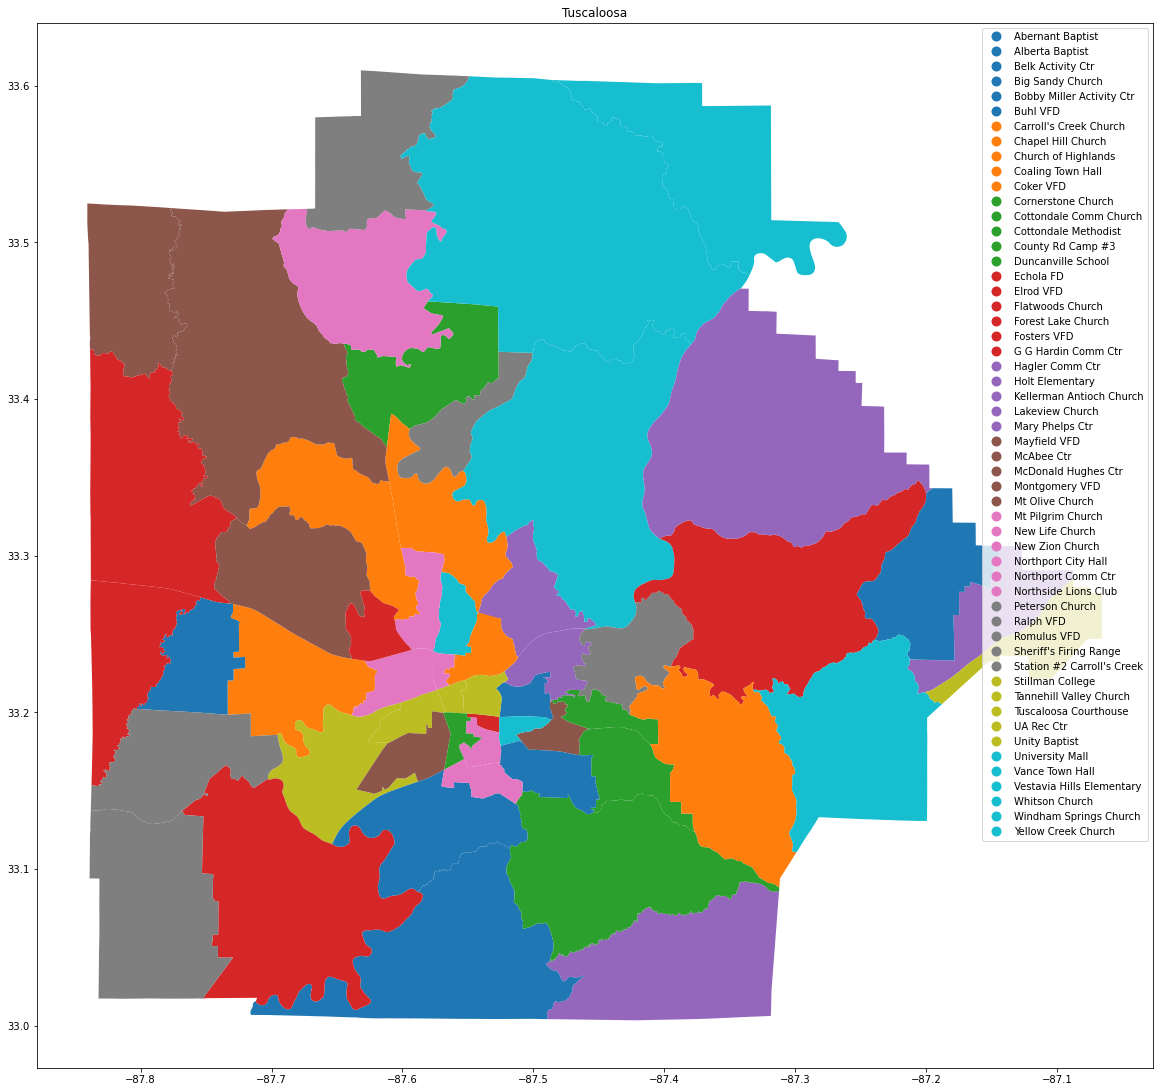

In [39]:
al_fips_dict_mod = dict(zip(fips_file["County Name"],fips_file["FIPS County"]))

alt_source = [ "De Kalb", "Franklin", "Jefferson", "Lee", "Marengo", "Marshall", "Tuscaloosa"]

for county in alt_source:
    plt = vest_al_17[vest_al_17["COUNTYFP20"]==al_fips_dict_mod[county]].plot(figsize=(20,20),column="NAME17",legend=True)
    plt.set_title(county)

# Shapefile Validation

In [40]:
shapefile_election = attempt_two[attempt_two["_merge"]=="both"]
attempt_two = pd.merge(tiger_vtd,non_prov_absentee,indicator=True,how="outer",on="unique_ID")
print(attempt_two["_merge"].value_counts())
final_merge = pd.merge(vest_al_17,shapefile_election,indicator="final_merge",how="outer",on="unique_ID")

NameError: name 'attempt_two' is not defined

In [ ]:
both = final_merge[final_merge["final_merge"]=="both"]
vest_geoms = gp.GeoDataFrame(both,geometry="geometry_x",crs=vest_al_20.crs)
source_geoms = gp.GeoDataFrame(both,geometry="geometry_y",crs=vest_al_20.crs)
source_geoms = source_geoms.to_crs(3857)
vest_geoms = vest_geoms.to_crs(3857)
source_geoms["geometry_x"]=source_geoms.buffer(0)
vest_geoms["geometry_y"]=vest_geoms.buffer(0)
vals = source_geoms.geom_almost_equals(vest_geoms,decimal=0)
print(vals.value_counts())

In [ ]:
count = 0
area_list = []
for i in range(0,len(source_geoms)):
    diff = source_geoms.iloc[[i]].symmetric_difference(vest_geoms.iloc[[i]])
    intersection = source_geoms.iloc[[i]].intersection(vest_geoms.iloc[[i]])
    area = float(diff.area/10e6)
    area_list.append(area)
    #print("Area is " + str(area))

    if (area > .1):
        count += 1
        name = source_geoms.iat[i,2]
        
        print(str(count)+") For " + name + " difference in area is " + str(area))
        if (intersection.iloc[0].is_empty):
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            base.set_title(name)
        else:
            base = diff.plot(color="red")
            source_geoms.iloc[[i]].plot(color="orange",ax=base)
            vest_geoms.iloc[[i]].plot(color="blue",ax=base)
            intersection.plot(color="green",ax=base)
            base.set_title(name)

In [ ]:
df = pd.DataFrame(area_list)
print(df.shape)

print(str(len(df[df[0]==0]))+" precincts w/ a difference of 0 km^2")
print(str(len(df[(df[0]<.1) & (df[0]>0)]))+ " precincts w/ a difference between 0 and .1 km^2")
print(str(len(df[(df[0]<.5) & (df[0]>=.1)]))+ " precincts w/ a difference between .1 and .5 km^2")
print(str(len(df[(df[0]<1) & (df[0]>=.5)]))+ " precincts w/ a difference between .5 and 1 km^2")
print(str(len(df[(df[0]<2) & (df[0]>=1)]))+ " precincts w/ a difference between 1 and 2 km^2")
print(str(len(df[(df[0]<5) & (df[0]>=2)]))+ " precincts w/ a difference between 2 and 5 km^2")
print(str(len(df[(df[0]>=5)]))+ " precincts w/ a difference greater than 5 km^2")